<h1 align="center"> Chapter 6: Exploiting Generative Adversarial Networks for credit card fraud detection on real data </h1>


<h2> Introduction </h2>
The purpose of this project is to implement a Generative Adversarial Network as an oversampling method for the imbalanced problem of credit card fraud detection. We will propose it as an alternative to the very popular SMOTE oversampling technique and Random Undersampling. The dataset "credit card fraud detection" has been downloaded from Kaggle. It contains 284,807 transactions, 492 of which have been classified as frauds.  Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'.

<h2> Our Goals: </h2>
<ul>
<li> Understand the  class and features distribution of our Dataset </li>
<li> Implement different oversampling and undersampling techniques to deal with our imbalanced dataset</li>
<li> Determine the Classifiers we are going to use based on specific performance measures other than from Accuracy)  </li>
<li> Analyze the economic impact of our algorithm on an average company in the market</li>
</ul>


<h2> Index: </h2>

I. <b>Data Analysis </b><br>
1.1) [Gather Sense of our data](#da) <br><br>

II. <b>Data preparation</b><br>
2.1) [Data clearing: dropping duplicates ](#distributing)<br>
2.2) [Scaling and Distributing](#distributing)<br>
2.3) [Train and Test set creation](#splitting)<br><br>

III. <b>Oversampling with GAN</b><br>
3.1) [GAN definition](#anomaly)<br>
3.2) [Generating new data using GAN](#anomaly)<br>
3.3) [Classification without cross validation](#anomaly)<br>
3.4) [Performance and testing](#logistic)<br><br> 


IV. <b>SMOTE Oversampling</b><br>
4.1) [Implementation and classification](#classifiers)<br>
4.2) [Performance and Testing](#logistic)<br><br> 

V. <b>Model comparison </b><br>
5.1) [Confusion matrices](#testing_logistic)<br>
5.2) [Economic Analysis](#neural_networks)

<h2> References: </h2>
<ul> 
<li>Hands on Machine Learning with Scikit-Learn & TensorFlow by Aurélien Géron (O'Reilly). CopyRight 2017 Aurélien Géron  </li>
<li><a src="https://www.youtube.com/watch?v=DQC_YE3I5ig&t=794s" > Machine Learning - Over-& Undersampling - Python/ Scikit/ Scikit-Imblearn </a>by Coding-Maniac</li>
<li><a src="https://www.kaggle.com/lane203j/auprc-5-fold-c-v-and-resampling-methods"> auprc, 5-fold c-v, and resampling methods
</a> by Jeremy Lane (Kaggle Notebook) </li>
</ul>

# **I. DATA ANALYSIS**
<a id="da"></a>

## 1.1 Gather sense of our data

In [1]:
# Load shared functions
!curl -O https://raw.githubusercontent.com/leonardoimperit/thesis-timperi/main/shared_functions_imports.py
%run shared_functions_imports.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4862  100  4862    0     0  19526      0 --:--:-- --:--:-- --:--:-- 19526


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be import

In [2]:
# Importing Libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

#GAN Libraries
%matplotlib inline
import os
import random
from tqdm import tqdm_notebook as tqdm
from keras.models import Model
from keras.layers import Input, Reshape, GaussianNoise
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling1D, Conv1D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, SGD
from keras.callbacks import TensorBoard

In [3]:

#mounting google drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#uploading the dataset
df = pd.read_csv('/content/drive/MyDrive/creditcard 2.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


We perform a brief Data Analysis to check that the upload was carried out correctly

In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


We check the proportion of frauds and no frauds

In [6]:
# The classes are heavily skewed we need to solve this issue later.
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

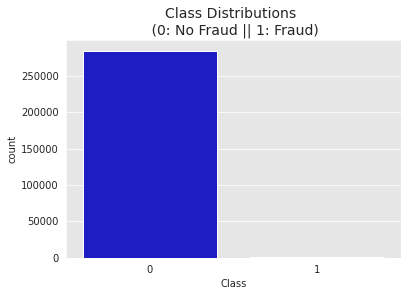

In [7]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('Class', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

Here we give a look to the 2 easiest to interpret variables: Amount and Time.

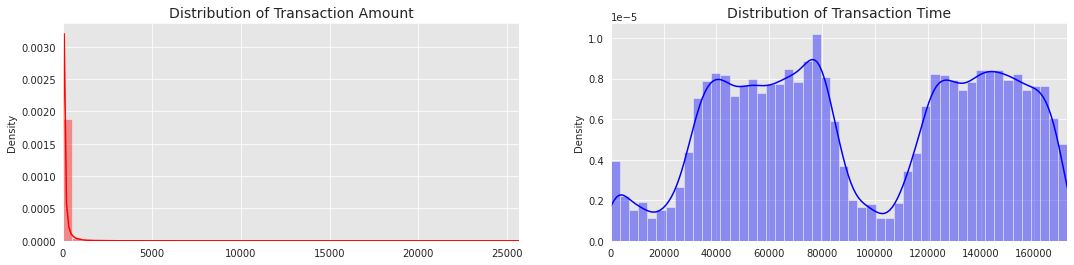

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])



plt.show()

We now give a look to the whole distribution of features 

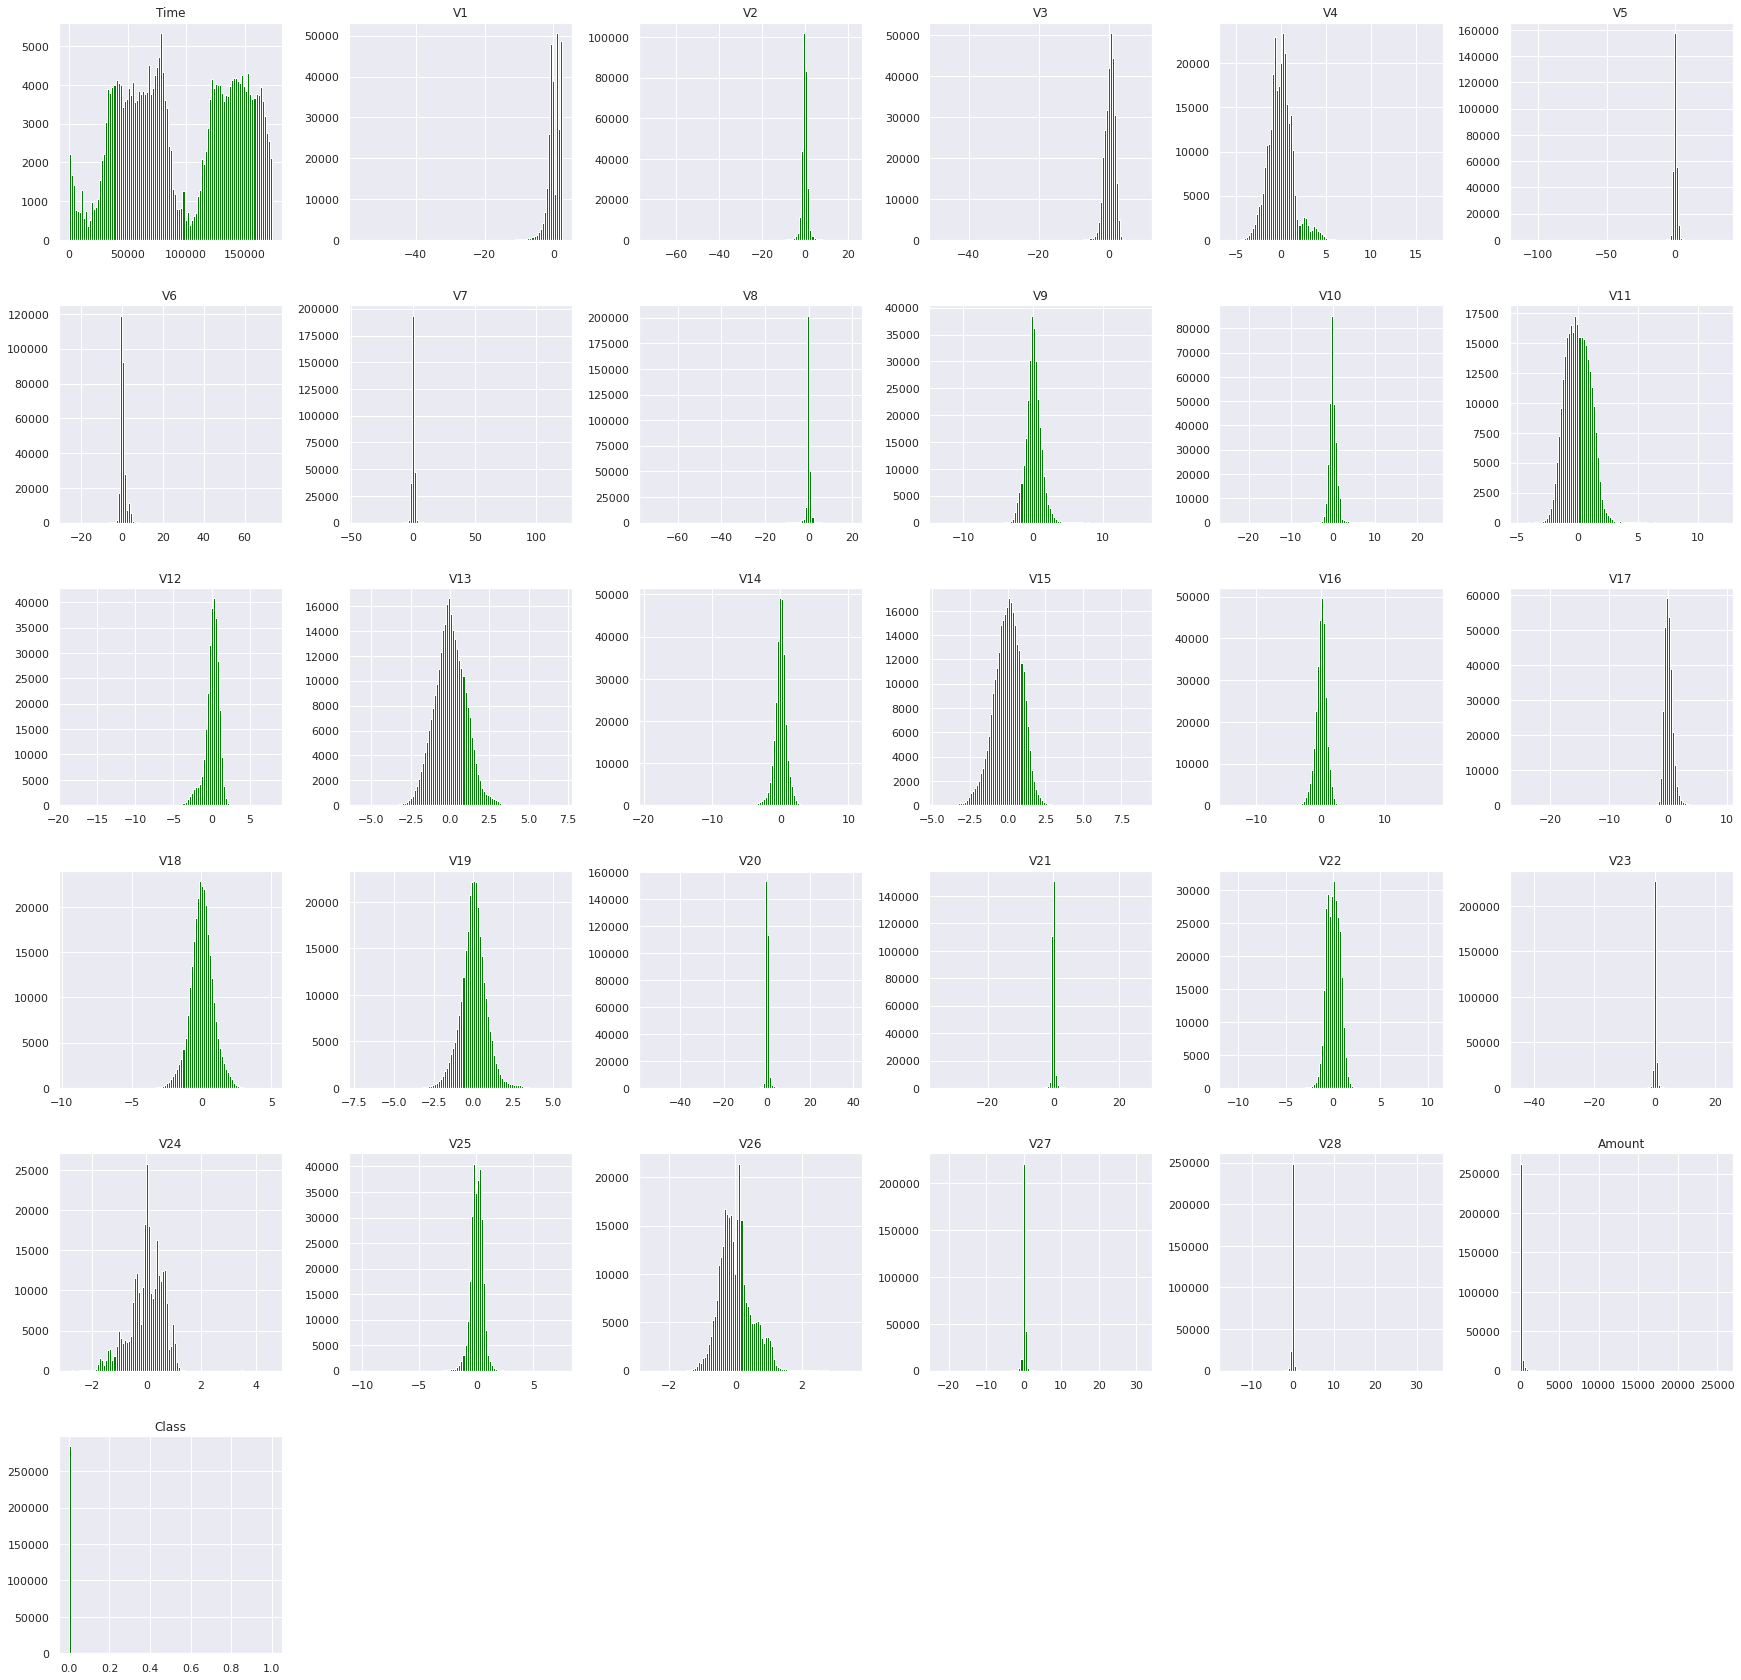

In [9]:
%matplotlib inline  
sns.set()
df.hist(bins=100, figsize=(30, 30), color='green')
plt.show()

A brief correlation matrix analysis to detect the presence of correlated features that can undermine the performance of our classificators. Also this is important to see whether some features are strongly correlated with our output feature

In [ ]:
features= df.drop('Class',axis=1)
corr_matrix = features.corr()

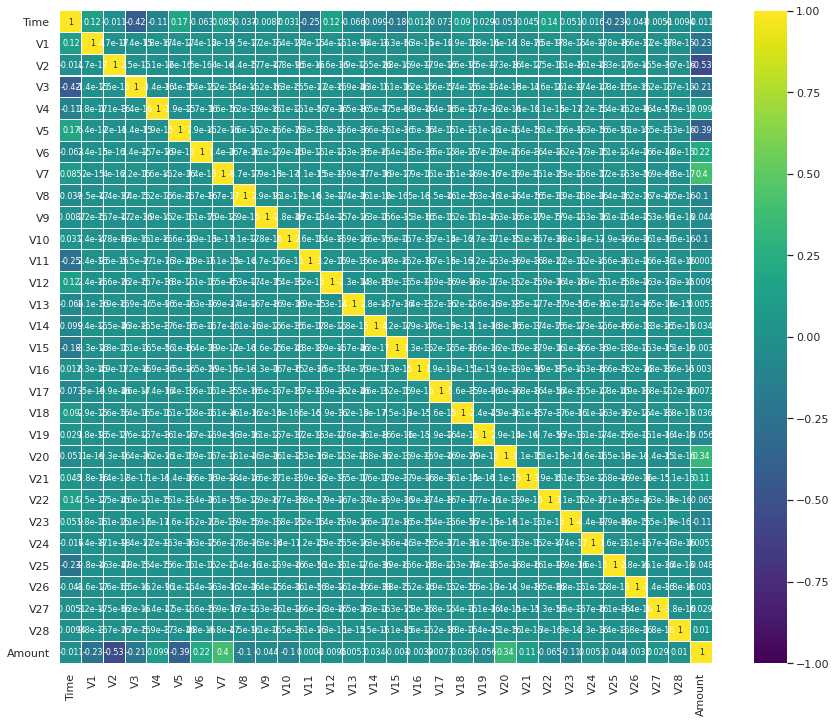

In [ ]:
fig, ax = plt.subplots(figsize=(15,12))     

sns.heatmap(corr_matrix,cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size":8}, square=True, ax=ax)

Here we check whether the distribution of our variables resembles a normal distribution. Indeed it seems the case for most variable: this is because the data provided are the result of a Principal Component Analysis

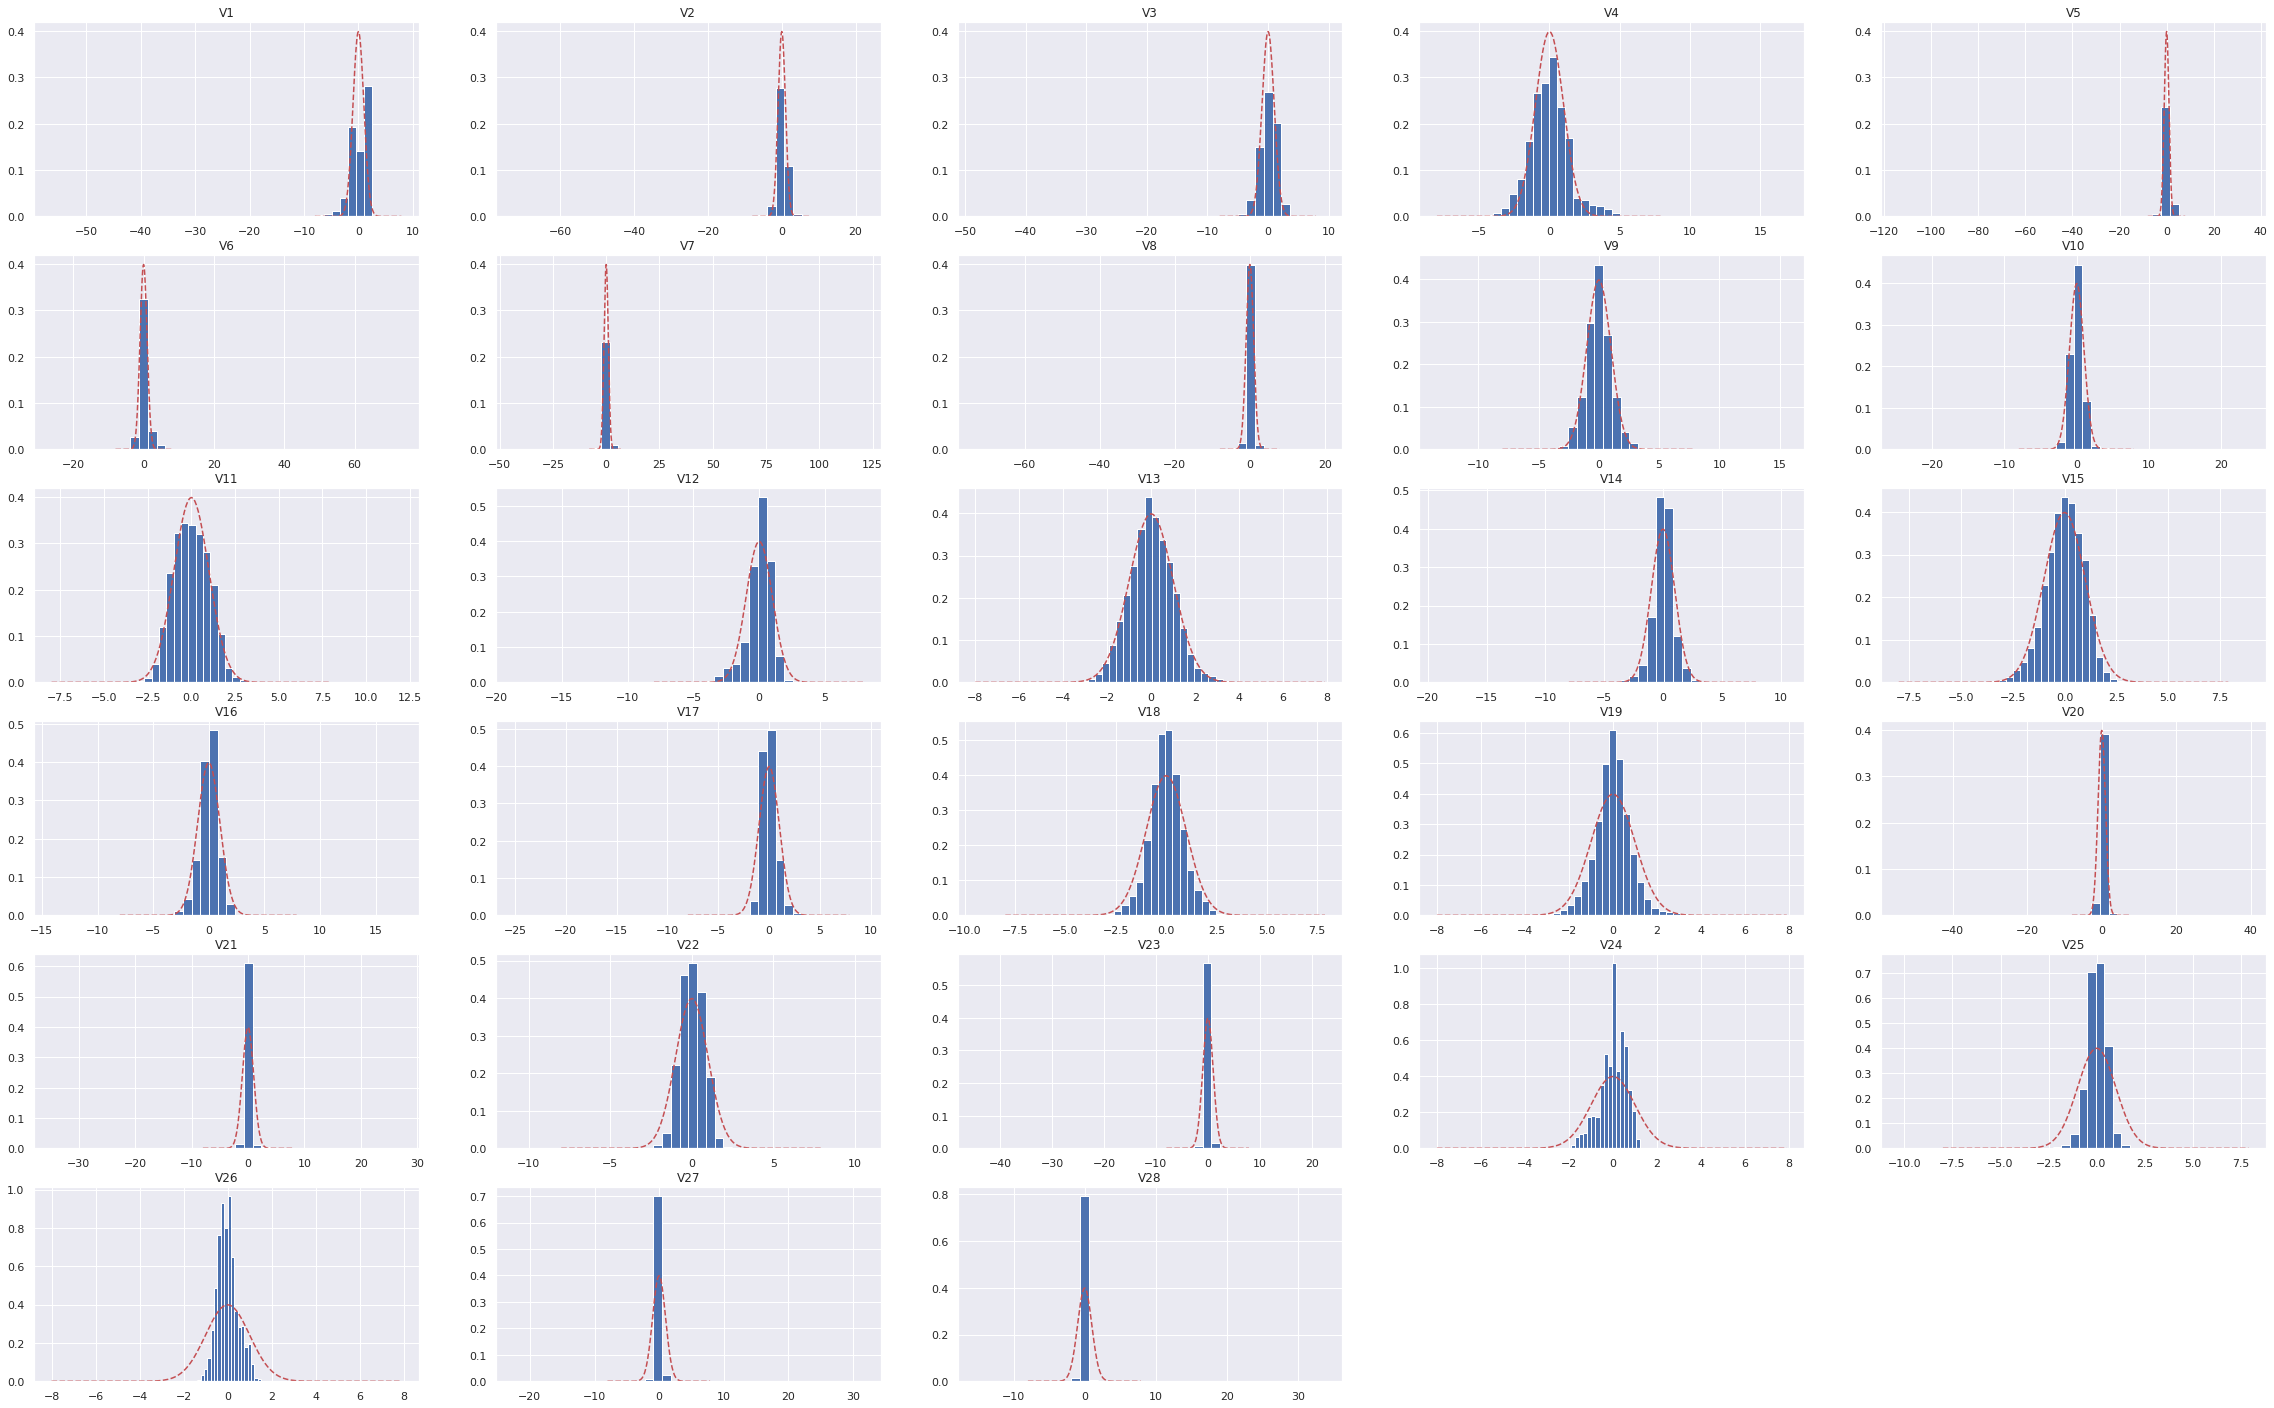

In [ ]:
for i in range(1,29):    # we have 20 features ranging from feature_1 to feature_20
    vfeature = 'V' + str(i)
    plt.subplot(6, 5, i)
    df[vfeature].hist(bins=40, figsize=(40,25), density=1)
    x = np.arange(-8,8,0.1)
    y = (1/(np.sqrt(2*np.pi))) * np.exp(-0.5*(x**2))
    plt.title(vfeature)
    plt.plot(x,y, "--", c="r")

# **II. DATA PREPARATION**

##2.1 Data clearing: dropping duplicates

here we eliminate the duplicated features

In [10]:
df.drop_duplicates(inplace = True)

In [11]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [12]:
# The classes are heavily skewed we need to solve this issue later.
print('No Frauds', df['Class'].value_counts()[0],  round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', df['Class'].value_counts()[1],round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 283253 99.83 % of the dataset
Frauds 473 0.17 % of the dataset


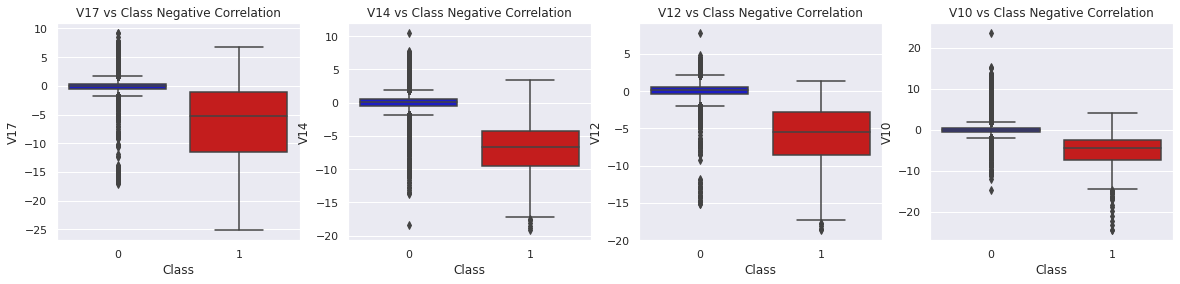

In [13]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V17", data=df, palette=colors, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=df, palette=colors, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=df, palette=colors, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=df, palette=colors, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

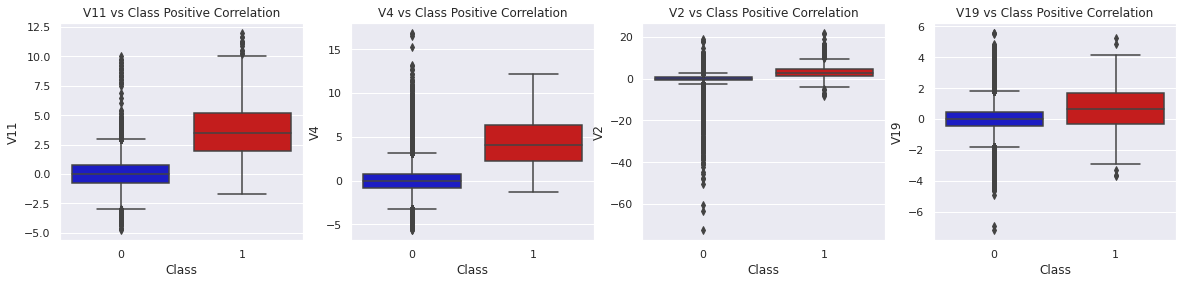

In [14]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="Class", y="V11", data=df, palette=colors, ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=df, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=df, palette=colors, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=df, palette=colors, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()

In [15]:
# # -----> V14 Removing Outliers (Highest Negative Correlated with Labels)
v14_fraud = df['V14'].loc[df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))
df['V14'] = df['V14'].apply(lambda x: x if x < v14_upper else v14_upper)
df['V14'] = df['V14'].apply(lambda x: x if x > v14_lower else v14_lower)
#new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)

print('----' * 44)

# -----> V12 removing outliers from fraud transactions
v12_fraud = df['V12'].loc[df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
#new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
df['V12'] = df['V12'].apply(lambda x: x if x < v12_upper else v12_upper)
df['V12'] = df['V12'].apply(lambda x: x if x > v12_lower else v12_lower)
print('----' * 44)


# Removing outliers V10 Feature
v10_fraud = df['V10'].loc[df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
df['V10'] = df['V10'].apply(lambda x: x if x < v10_upper else v10_upper)
df['V10'] = df['V10'].apply(lambda x: x if x > v10_lower else v10_lower)
#new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)



Quartile 25: -9.50514082568186 | Quartile 75: -4.25246559869278
iqr: 5.25267522698908
Cut Off: 7.87901284048362
V14 Lower: -17.38415366616548
V14 Upper: 3.62654724179084
Feature V14 Outliers for Fraud Cases: 7
V10 outliers:[-19.2143254902614, -18.8220867423816, -18.4937733551053, -18.049997689859396, -17.7216383537133, -17.4759212828566, -17.6206343516773]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Lower: -17.266702219761186
V12 Upper: 5.840108332229608
V12 outliers: [-17.7691434633638, -17.631606313870698, -18.047596570821604, -18.683714633344298, -18.553697009645802, -18.4311310279993]
Feature V12 Outliers for Fraud Cases: 6
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V10 Lower: -14.57330449236926
V10 Upper: 4.8280318

## 2.2 Scaling##

Here we rescale all the features in the interval [0,1]. This will be important for the GANs training in the later step


In [16]:
input_features = ['Time', 'Amount', 'V1', 	'V2', 	'V3', 	'V4', 	'V5', 	'V6', 	'V7', 	'V8', 	'V9', 	'V10', 	'V11', 	'V12', 	'V13', 	'V14', 	'V15', 	'V16', 	'V17', 	'V18', 	'V19', 	'V20', 	'V21', 	'V22', 	'V23', 	'V24', 	'V25', 	'V26', 	'V27', 	'V28']

In [17]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

# RobustScaler is less prone to outliers.

#std_scaler = StandardScaler()
#rob_scaler = RobustScaler() #it would be nice to put some parameters and see what is the best thing here. 
minmax_scaler = MinMaxScaler()

df[input_features] = minmax_scaler.fit_transform(df[input_features])
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,0.935192,0.766490,0.881365,0.313023,0.763439,0.267669,0.266815,0.786444,0.475312,0.755829,0.252484,0.720519,0.371591,0.812585,0.446084,0.434392,0.737173,0.655066,0.594863,0.582942,0.561184,0.522992,0.663793,0.391253,0.585122,0.394557,0.418976,0.312697,0.005824,0
1,0.000000,0.978542,0.770067,0.840298,0.271796,0.766120,0.262192,0.264875,0.786298,0.453981,0.742543,0.381188,0.793356,0.486190,0.820552,0.383840,0.464105,0.727794,0.640681,0.551930,0.579530,0.557840,0.480237,0.666938,0.336440,0.587290,0.446013,0.416345,0.313423,0.000105,0
2,0.000006,0.935217,0.753118,0.868141,0.268766,0.762329,0.281122,0.270177,0.788042,0.410603,0.761852,0.322422,0.750116,0.503854,0.819497,0.511697,0.357443,0.763381,0.644945,0.386683,0.585855,0.565477,0.546030,0.678939,0.289354,0.559515,0.402727,0.415489,0.311911,0.014739,0
3,0.000006,0.941878,0.765304,0.868484,0.213661,0.765647,0.275559,0.266803,0.789434,0.414999,0.748317,0.271817,0.754969,0.487635,0.813692,0.289124,0.415653,0.711253,0.788492,0.467058,0.578050,0.559734,0.510277,0.662607,0.223826,0.614245,0.389197,0.417669,0.314371,0.004807,0
4,0.000012,0.938617,0.776520,0.864251,0.269796,0.762975,0.263984,0.268968,0.782484,0.490950,0.789965,0.236355,0.770548,0.552509,0.774105,0.349419,0.434995,0.724243,0.650665,0.626060,0.584615,0.561327,0.547271,0.663392,0.401270,0.566343,0.507497,0.420561,0.317490,0.002724,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,0.999965,0.756448,0.873531,0.666991,0.160317,0.729603,0.236810,0.235393,0.863749,0.528729,0.975679,0.190550,0.864621,0.394978,1.000000,0.267218,0.484577,0.789000,0.688412,0.509985,0.595979,0.564920,0.515249,0.680500,0.313600,0.658558,0.466291,0.433929,0.329840,0.000030,0
284803,0.999971,0.945845,0.766677,0.872678,0.219189,0.771561,0.273661,0.265504,0.788548,0.482925,0.700848,0.276355,0.786889,0.542361,0.795262,0.423414,0.426717,0.730383,0.569303,0.442620,0.580900,0.564933,0.553153,0.665619,0.245298,0.543855,0.360884,0.417775,0.312038,0.000965,0
284804,0.999977,0.990905,0.764080,0.781102,0.227202,0.783425,0.293496,0.263547,0.792985,0.477677,0.726162,0.309763,0.749988,0.434111,0.803093,0.435700,0.453827,0.740239,0.680504,0.518236,0.580280,0.565220,0.537005,0.664877,0.468492,0.592824,0.411177,0.416593,0.312585,0.002642,0
284805,0.999977,0.954209,0.772856,0.849587,0.282508,0.763172,0.269291,0.261175,0.792671,0.476287,0.730577,0.170288,0.705585,0.367667,0.848795,0.483042,0.429998,0.745946,0.729908,0.789612,0.581622,0.565755,0.547353,0.663008,0.398836,0.545958,0.514746,0.418520,0.315245,0.000389,0


In [18]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,0.548701,0.958394,0.767215,0.837442,0.251799,0.765729,0.263008,0.265366,0.785376,0.462725,0.750444,0.285298,0.747226,0.448378,0.827349,0.336405,0.449389,0.731135,0.653396,0.563294,0.580267,0.561474,0.510030,0.665437,0.382263,0.577894,0.425473,0.416543,0.313135,0.003444,0.001667
std,0.274787,0.033095,0.017375,0.026143,0.062690,0.009270,0.013391,0.007479,0.012648,0.037738,0.050933,0.060579,0.043030,0.077053,0.045011,0.068395,0.027785,0.024480,0.057592,0.063518,0.008198,0.011670,0.033800,0.009263,0.081608,0.029257,0.078742,0.007305,0.006657,0.009747,0.040796
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.313699,0.942733,0.760924,0.821997,0.214244,0.761072,0.255288,0.261990,0.783145,0.440588,0.723544,0.239994,0.729677,0.398182,0.807133,0.292860,0.434505,0.717069,0.619040,0.527683,0.578014,0.557799,0.484714,0.663032,0.334472,0.560085,0.372072,0.415207,0.312052,0.000218,0.000000
50%,0.490141,0.958640,0.767933,0.840532,0.250944,0.765356,0.260253,0.265604,0.785620,0.460968,0.746344,0.283365,0.753275,0.447330,0.829785,0.340013,0.451486,0.729216,0.653145,0.563578,0.579601,0.561005,0.510342,0.665268,0.387761,0.578820,0.416926,0.416538,0.313353,0.000856,0.000000
75%,0.806160,0.980652,0.775703,0.855209,0.284718,0.769838,0.267009,0.268831,0.788879,0.483310,0.774530,0.329265,0.773957,0.499665,0.850828,0.384927,0.466000,0.742722,0.687815,0.599120,0.581684,0.564481,0.534674,0.667628,0.441489,0.597590,0.464695,0.418194,0.314712,0.003017,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df.to_csv('/content/drive/MyDrive/Colab Notebooks/tesi/Versione agosto/CHAPTER 6: APPLICATION ON A REAL DATASET/transformed dataset/transormed_dataset.csv')

## 2.2 Train and Test Splitting

In this section we perform a standard Train/Test splitting. We divide our test set to be 20% of the total dataset. Since our dataset contains a sufficiently big number of transactions, this should be enough to evaluate our models.

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values
original_Xtrain_nofraudindex = original_ytrain ==0
original_Xtrain_fraudindex = original_ytrain ==1
original_Xtest_nofraudindex = original_ytest ==0
original_Xtest_fraudindex = original_ytest ==1


#creating dataframes (it will become more useful later)
original_Xtrain_df = pd.DataFrame(original_Xtrain)
original_Xtrain_df.columns = X.columns
original_Xtest_df = pd.DataFrame(original_Xtest)
original_Xtest_df.columns = pd.DataFrame(original_Xtest).columns
original_Xtrain_df_fraud = original_Xtrain_df.iloc[original_Xtrain_fraudindex]
original_Xtrain_df_nofraud = original_Xtrain_df.iloc[original_Xtrain_nofraudindex]
original_Xtest_df_fraud = original_Xtest_df.iloc[original_Xtest_fraudindex]
original_Xtest_df_nofraud = original_Xtest_df.iloc[original_Xtest_nofraudindex]


# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [ 30191  30261  30275 ... 283723 283724 283725] Test: [    0     1     2 ... 56805 56806 56807]
Train: [     0      1      2 ... 283723 283724 283725] Test: [ 30191  30261  30275 ... 113535 113536 113537]
Train: [     0      1      2 ... 283723 283724 283725] Test: [ 77084  77379  79220 ... 170292 170293 170294]
Train: [     0      1      2 ... 283723 283724 283725] Test: [149302 150027 150068 ... 226999 227000 227001]
Train: [     0      1      2 ... 226999 227000 227001] Test: [212341 212365 213905 ... 283723 283724 283725]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99833466 0.00166534]
[0.99832584 0.00167416]


In [27]:
np.size(original_ytest)

56745

The proportion of frauds is similar on the test and train set. This means that we performed our splitting correctly

# **III GAN OVERSAMPLING**
We arrive here to the center of our analysis. In the first section we will try to create and train a Generative Adversarial Network. In the second section we will employ as an oversampling method with the aim to solve our imbalance classification problem


## 3.1 Creation of a Generative Adversarial Network

We start by importing the required packages. We will use tensorflow keras developed by google, which runs the google colab platform

In [ ]:
import tensorflow as tf
from random import randint
import sys

from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
# example of loading the mnist dataset

Our first step is the creation of a Discriminator class. The network here is just a preliminary one with default loss and activation functions and just 3 layers.

In [ ]:
class Discriminator(object):
       def __init__(self, number_features = 30,
                    latent_size=100):
           # Initialize Variables
            self.CAPACITY = number_features
            self.SHAPE = (number_features,)
            self.OPTIMIZER = Adam(lr=0.0002, decay=8e-9)
            self.Discriminator = self.model()
            self.Discriminator.compile(loss='binary_crossentropy',
                               optimizer=self.OPTIMIZER, metrics=['accuracy'] )
            self.Discriminator.summary()
       def model(self):
           # Build the binary classifier and return it
            model = Sequential()
            model.add(Flatten(input_shape=self.SHAPE))
            model.add(Dense(self.CAPACITY, input_shape=self.SHAPE))
            model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
            model.add(Dense(int(self.CAPACITY/2)))
            model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
            model.add(Dense(1, activation='sigmoid'))
            return model
       def summary(self):
            return self.Discriminator.summary()
           # Prints the Model Summary to the Screen

The same is true here for our generator. It is a simple neural network with the number of layers as parameters. Here 4 is set as the default. Loss functions and optimnizers are still default ones.

In [ ]:
class Generator(object):
       def __init__(self, number_features = 30,
                    latent_size=100, num_blocks = 4):
            # Initialize Variables
           self.number_features = number_features 
           self.num_blocks = num_blocks
           self.OPTIMIZER = Adam(lr=0.0002, decay=8e-9)
           self.LATENT_SPACE_SIZE = latent_size
           self.latent_space = np.random.normal(0,1,
                                           (self.LATENT_SPACE_SIZE,))
           self.Generator = self.model()
           self.Generator.compile(loss='binary_crossentropy',
                                  optimizer=self.OPTIMIZER)
           self.Generator.summary()
            
       def model(self, block_starting_size=64):
           model = Sequential()
           block_size = block_starting_size
           model.add(Dense(block_size, input_shape=(self.LATENT_SPACE_SIZE,)))
           model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
           model.add(BatchNormalization(momentum=0.8))
           for i in range(self.num_blocks-1):
                            block_size = block_size 
                            model.add(Dense(block_size))
                            model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
                            model.add(BatchNormalization(momentum=0.8))
           model.add(Dense(self.number_features , activation='sigmoid'))
           model.add(Reshape((self.number_features, )))
           return model
           # Build the generator model and returns it
       def summary(self):
           return self.Generator.summary()
           # Prints the Model Summary to the screen
       #def save_model(self):
           # Saves the model structure to a file in the data folder

Finally our GAN network is created! It is defined as just the sum of the Discriminator and the Generator networks. 

In [ ]:
class GAN(object):
       def __init__(self, discriminator,generator):
           self.OPTIMIZER = Adam(lr=0.0002, decay=8e-9)
           self.Generator = generator
           self.Discriminator = discriminator
           self.Discriminator.trainable = False
           self.gan_model = self.model()
           self.gan_model.compile(loss='binary_crossentropy',
                                  optimizer=self.OPTIMIZER)
           self.gan_model.summary()

           # Initialize Variables
       def model(self):
           model = Sequential()
           model.add(self.Generator)
           model.add(self.Discriminator)
           return model

           # Build the adversarial model and return it
        
       def summary(self):
           return gan_model.summary()
           # Prints the Model Summary to the Screen

Here we have the Trainer Class. What is very important here is to define it in a way that the GAN can learn in an adversarial way. For each step we will have that when the generator learns the discriminator stop learning and viceversa. If we don't employ this simple strategy it will be impossible for the system to converge and provide acceptable results.

In [ ]:
class Trainer:
         def __init__(self, X_trainer, number_features = 30,latent_size=100, iterations =5000, batch=32, num_blocks = 4):
          self.X_train = np.array(X_trainer).copy()
          self.number_features = number_features 
          self.iterations = iterations
          self.BATCH = batch
          self.LATENT_SPACE_SIZE = latent_size
          self.generator = Generator(number_features=self.number_features, latent_size=self.LATENT_SPACE_SIZE, num_blocks = num_blocks )
          self.discriminator = Discriminator(number_features =self.number_features)
          self.gan = GAN(generator=self.generator.Generator, discriminator=self.discriminator.Discriminator)
          self.load_data()
         def sample_latent_space(self, instances):
                    return np.random.normal(0, 1,(instances,self.LATENT_SPACE_SIZE))
         def train(self):
                d_loss_list = np.array([])
                g_loss_list = np.array([])
                for e in range(self.iterations):
                  # Grab a batch
                    count_real_frauds = int(self.BATCH/2)
                    starting_index = randint(0, (len(self.X_train)-count_real_frauds))
                    real_frauds_raw = self.X_train[starting_index : (starting_index +count_real_frauds)]
                    x_real_frauds = real_frauds_raw.reshape( count_real_frauds, self.number_features)
                    y_real_labels = np.ones([count_real_frauds,1])
                    # Grab Generated Images for this training batch
                    latent_space_samples = self.sample_latent_space(count_real_frauds)
                    x_generated_frauds = self.generator.Generator.predict(latent_space_samples)
                    y_generated_labels = np.zeros([self.BATCH-count_real_frauds,1])
                    # Combine to train on the discriminator
                    x_batch = np.concatenate( [x_real_frauds, x_generated_frauds] )
                    y_batch = np.concatenate( [y_real_labels, y_generated_labels] )
                    # Now, train the discriminator with this batch
                    discriminator_loss  = self.discriminator.Discriminator.train_on_batch(x_batch,y_batch)[0]
                    d_loss_list = np.append(d_loss_list,discriminator_loss)
                    # Generate Noise
                    x_latent_space_samples = self.sample_latent_space(self.BATCH)
                    y_generated_labels = np.ones([self.BATCH,1])
                    generator_loss = self.gan.gan_model.train_on_batch(x_latent_space_samples,y_generated_labels)
                    g_loss_list = np.append(g_loss_list,generator_loss)
                    print ('Iterations:' + str(int(e)) + ', [Discriminator :: Loss:' + str(discriminator_loss)+'], [ Generator :: Loss:'+str(generator_loss)+']')
                return d_loss_list, g_loss_list
         def load_data(self):
                      self.X_train = np.float32(self.X_train)
                      self.X_train = np.expand_dims(self.X_train, axis=2)
                      return

The parameters are set in such a way that maximize  our performance measures. This were obtaines with a reference to theory and after some trial-and-error. We are still in a preliminary phase.

In [ ]:
#!/usr/bin/env python3
NUMBER_FEATURES  = 30
LATENT_SPACE_SIZE = 100
iterations = 2000
BATCH = 32
NUM_BLOCKS = 2
trainer = Trainer(X_trainer = original_Xtrain_df_fraud,number_features = NUMBER_FEATURES, latent_size=LATENT_SPACE_SIZE, iterations =iterations, batch=BATCH, num_blocks = NUM_BLOCKS)
d_loss, g_loss = trainer.train()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                6464      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 64)                256       
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 64)                256       
_________________________________________________________________
dense_14 (Dense)             (None, 30)               

This graph shows the behaviour of our generative and discriminative loss. We can see that there are some problems in the discriminator with relevant oscillation. However we can see that the scale of the difference is very small and overall the system does not diverge, despite the relatively significant variance through the epochs. Moreover we can see that the discriminative loss oscillate around 0.5, that is exactly the Nash Equilibrium that we expect for this type of networks.

Text(0, 0.5, 'Loss')

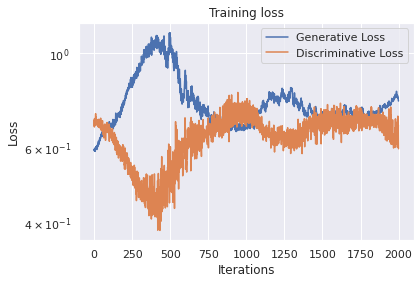

In [ ]:
import pandas as pd
ax = pd.DataFrame(
    {
        'Generative Loss': g_loss,
        'Discriminative Loss': d_loss,
    }
).plot(title='Training loss', logy=True)
ax.set_xlabel("Iterations")
ax.set_ylabel("Loss")

## 3.2 Creation of the oversampled dataset employing the trained GAN

The sample_latent_space function is fundamental to create variation in the generated frauds

In [ ]:
def sample_latent_space(instances, latent_space_size):
                    return np.random.normal(0, 1,(instances,latent_space_size))

In [ ]:
#for a balanced dataset we need to generate nofraud_df.shape[0] - fraud_df.shape[0] new transactions
proportion = [0.02,0.05,0.1,0.2,0.3,0.4,0.5]
balanced_datasets_gan = {}
proper__number_new_frauds_old = 0 
new_frauds_cumulative = pd.DataFrame()
for alpha in proportion: 
        proper__number_new_frauds_new = int((original_Xtrain_df.shape[0]*alpha - original_Xtrain_df_fraud.shape[0])/(1-alpha))
        number_new_frauds = proper__number_new_frauds_new - proper__number_new_frauds_old
        print(number_new_frauds)
        latent_space_samples = sample_latent_space(number_new_frauds,LATENT_SPACE_SIZE)
        new_generated_frauds = trainer.generator.Generator.predict(latent_space_samples)
        new_generated_frauds = np.reshape(new_generated_frauds,(number_new_frauds,30))
        new_frauds_gan = pd.DataFrame(new_generated_frauds)
        new_frauds_gan['Class'] = 1
        new_frauds_gan.columns = df.columns
        new_frauds_cumulative = new_frauds_cumulative.append(new_frauds_gan)
        original_nofraud_dftrain_with_class = original_Xtrain_df_nofraud.copy()
        original_nofraud_dftrain_with_class['Class']=0
        original_fraud_dftrain_with_class = original_Xtrain_df_fraud.copy()
        original_fraud_dftrain_with_class['Class']=1
        new_balanced_dataset_gan = pd.concat([original_nofraud_dftrain_with_class, original_fraud_dftrain_with_class, new_frauds_cumulative], axis = 0 )
        df_name = 'new_balanced_dataset_gan'+ str(alpha)
        balanced_datasets_gan[df_name] = new_balanced_dataset_gan
        proper__number_new_frauds_old = proper__number_new_frauds_new

4246
7302
13252
31472
40465
53953
75535


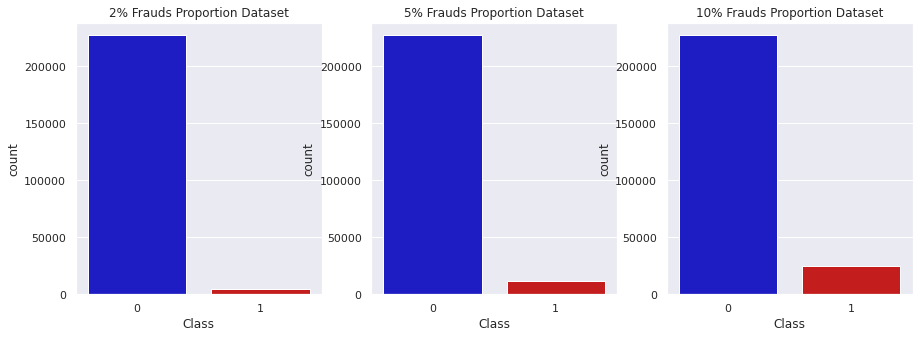

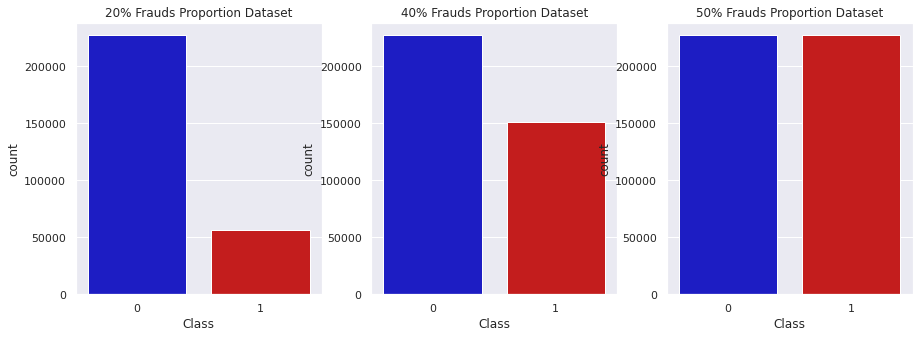

In [ ]:
colors = ["#0101DF", "#DF0101"]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

sns.countplot('Class', data= balanced_datasets_gan['new_balanced_dataset_gan0.02'], palette=colors, ax = axes[0])
axes[0].title.set_text('2% Frauds Proportion Dataset')

sns.countplot('Class', data= balanced_datasets_gan['new_balanced_dataset_gan0.05'], palette=colors, ax = axes[1])
axes[1].title.set_text('5% Frauds Proportion Dataset')

sns.countplot('Class', data= balanced_datasets_gan['new_balanced_dataset_gan0.1'], palette=colors, ax = axes[2])
axes[2].title.set_text('10% Frauds Proportion Dataset')
plt.show()
#print('Distribution of the Classes in the gan balanced dataset')
#print(new_balanced_dataset_gan['TX_FRAUD'].value_counts()/len(new_balanced_dataset_gan))

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

sns.countplot('Class', data= balanced_datasets_gan['new_balanced_dataset_gan0.2'], palette=colors, ax = axes[0])
axes[0].title.set_text('20% Frauds Proportion Dataset')

sns.countplot('Class', data= balanced_datasets_gan['new_balanced_dataset_gan0.4'], palette=colors, ax = axes[1])
axes[1].title.set_text('40% Frauds Proportion Dataset')

sns.countplot('Class', data= balanced_datasets_gan['new_balanced_dataset_gan0.5'], palette=colors, ax = axes[2])
axes[2].title.set_text('50% Frauds Proportion Dataset')
plt.show()

#sns.countplot('TX_FRAUD', data=new_balanced_dataset_gan, palette=colors)
#plt.title('Equally Distributed Classes', fontsize=14)
#plt.show()

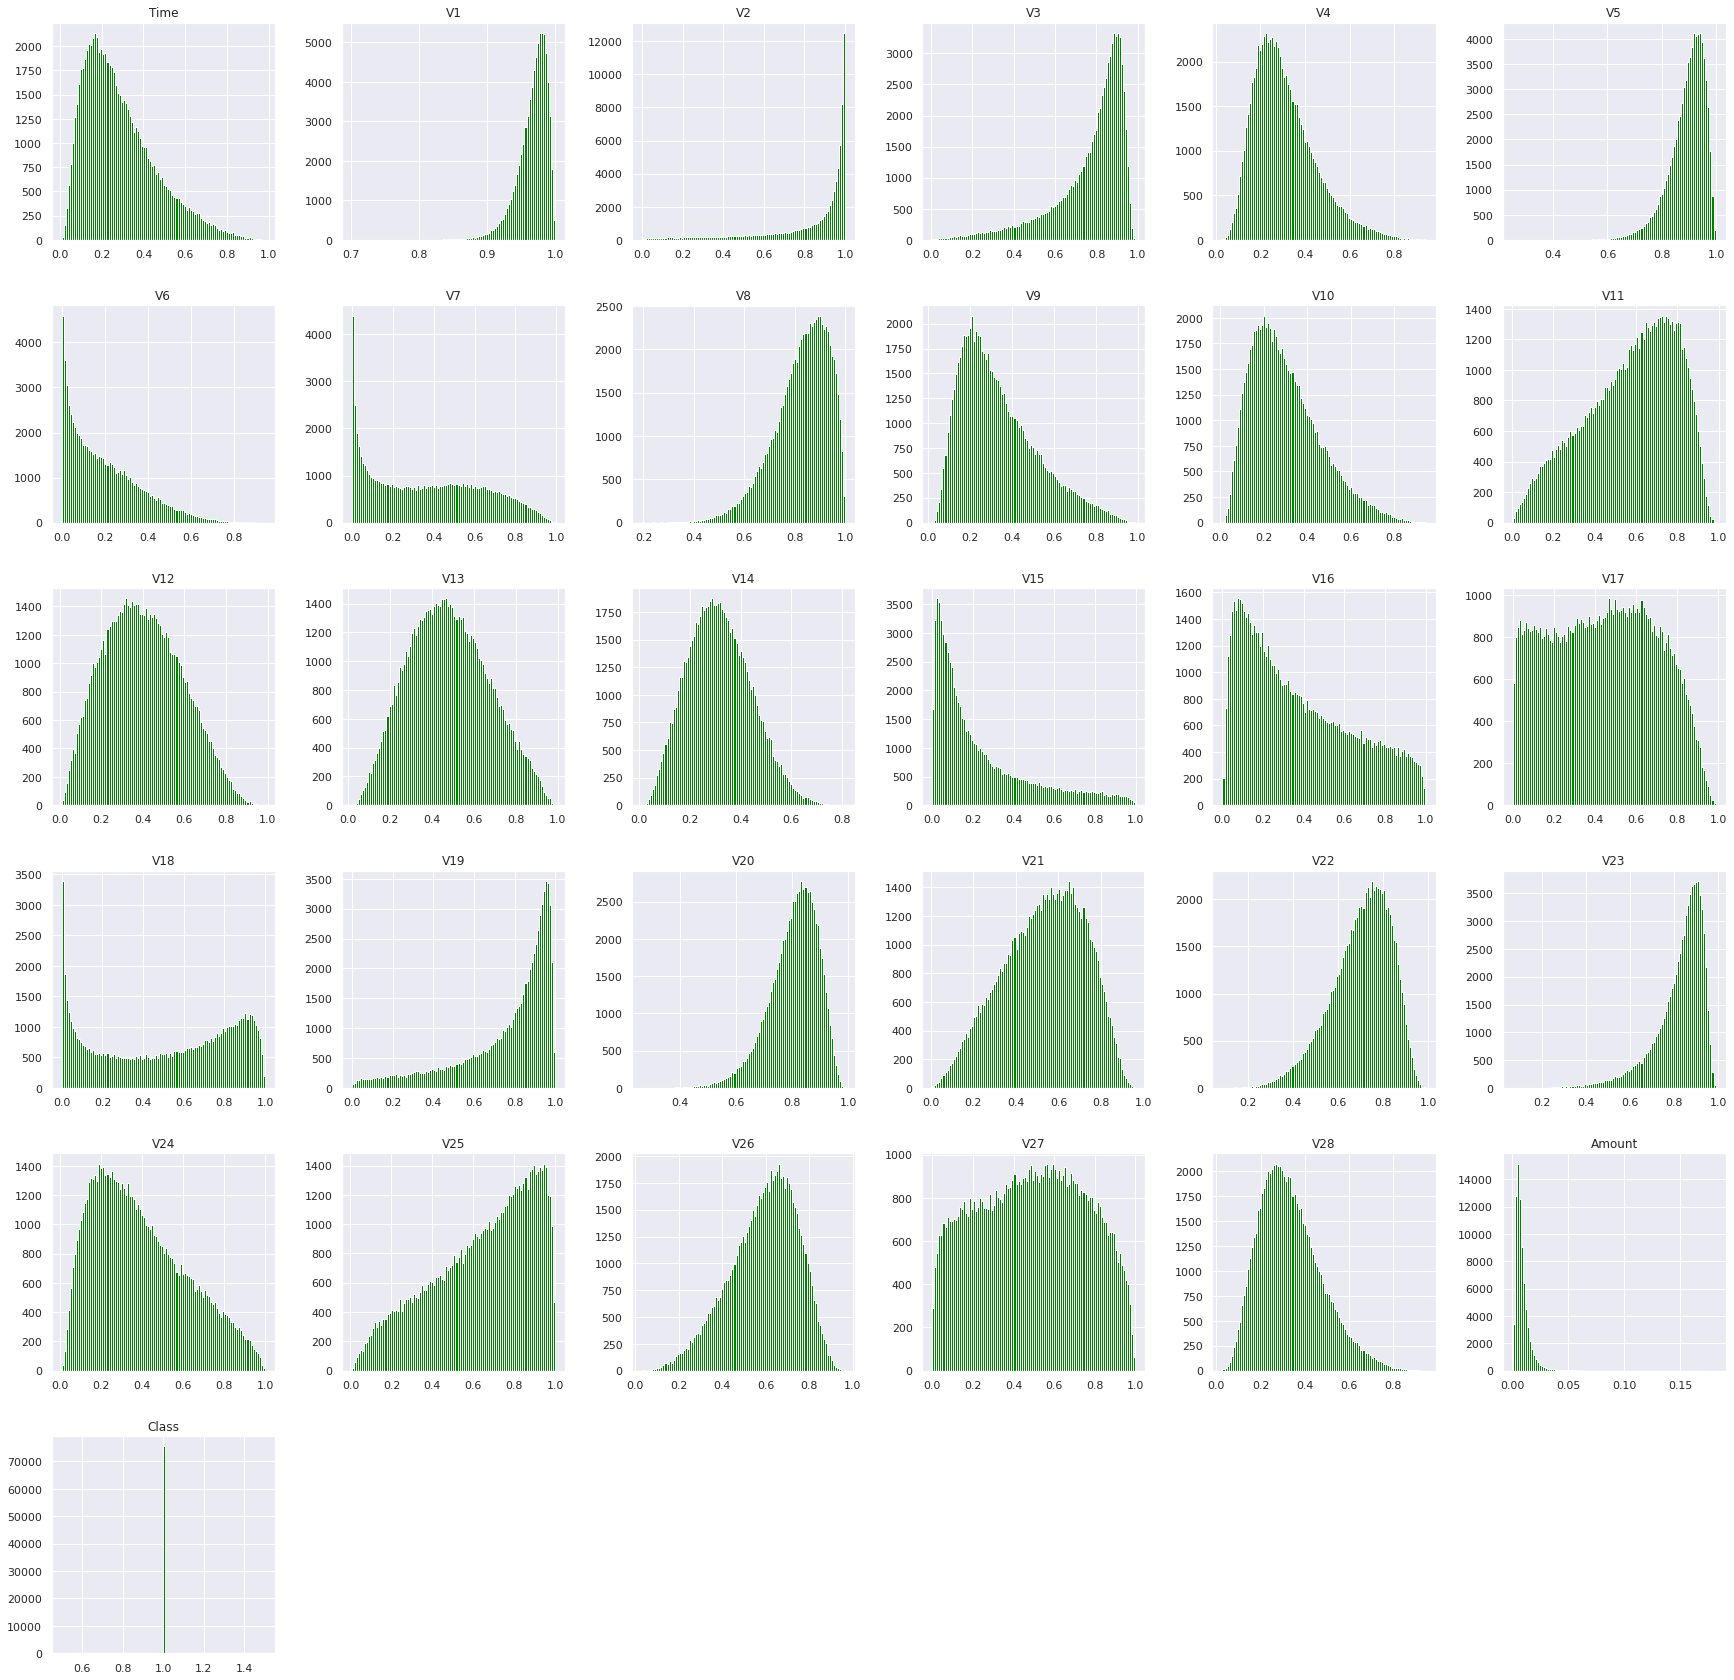

In [ ]:
%matplotlib inline  
sns.set()
new_frauds_gan.hist(bins=100, figsize=(30, 30), color='green')
plt.show()

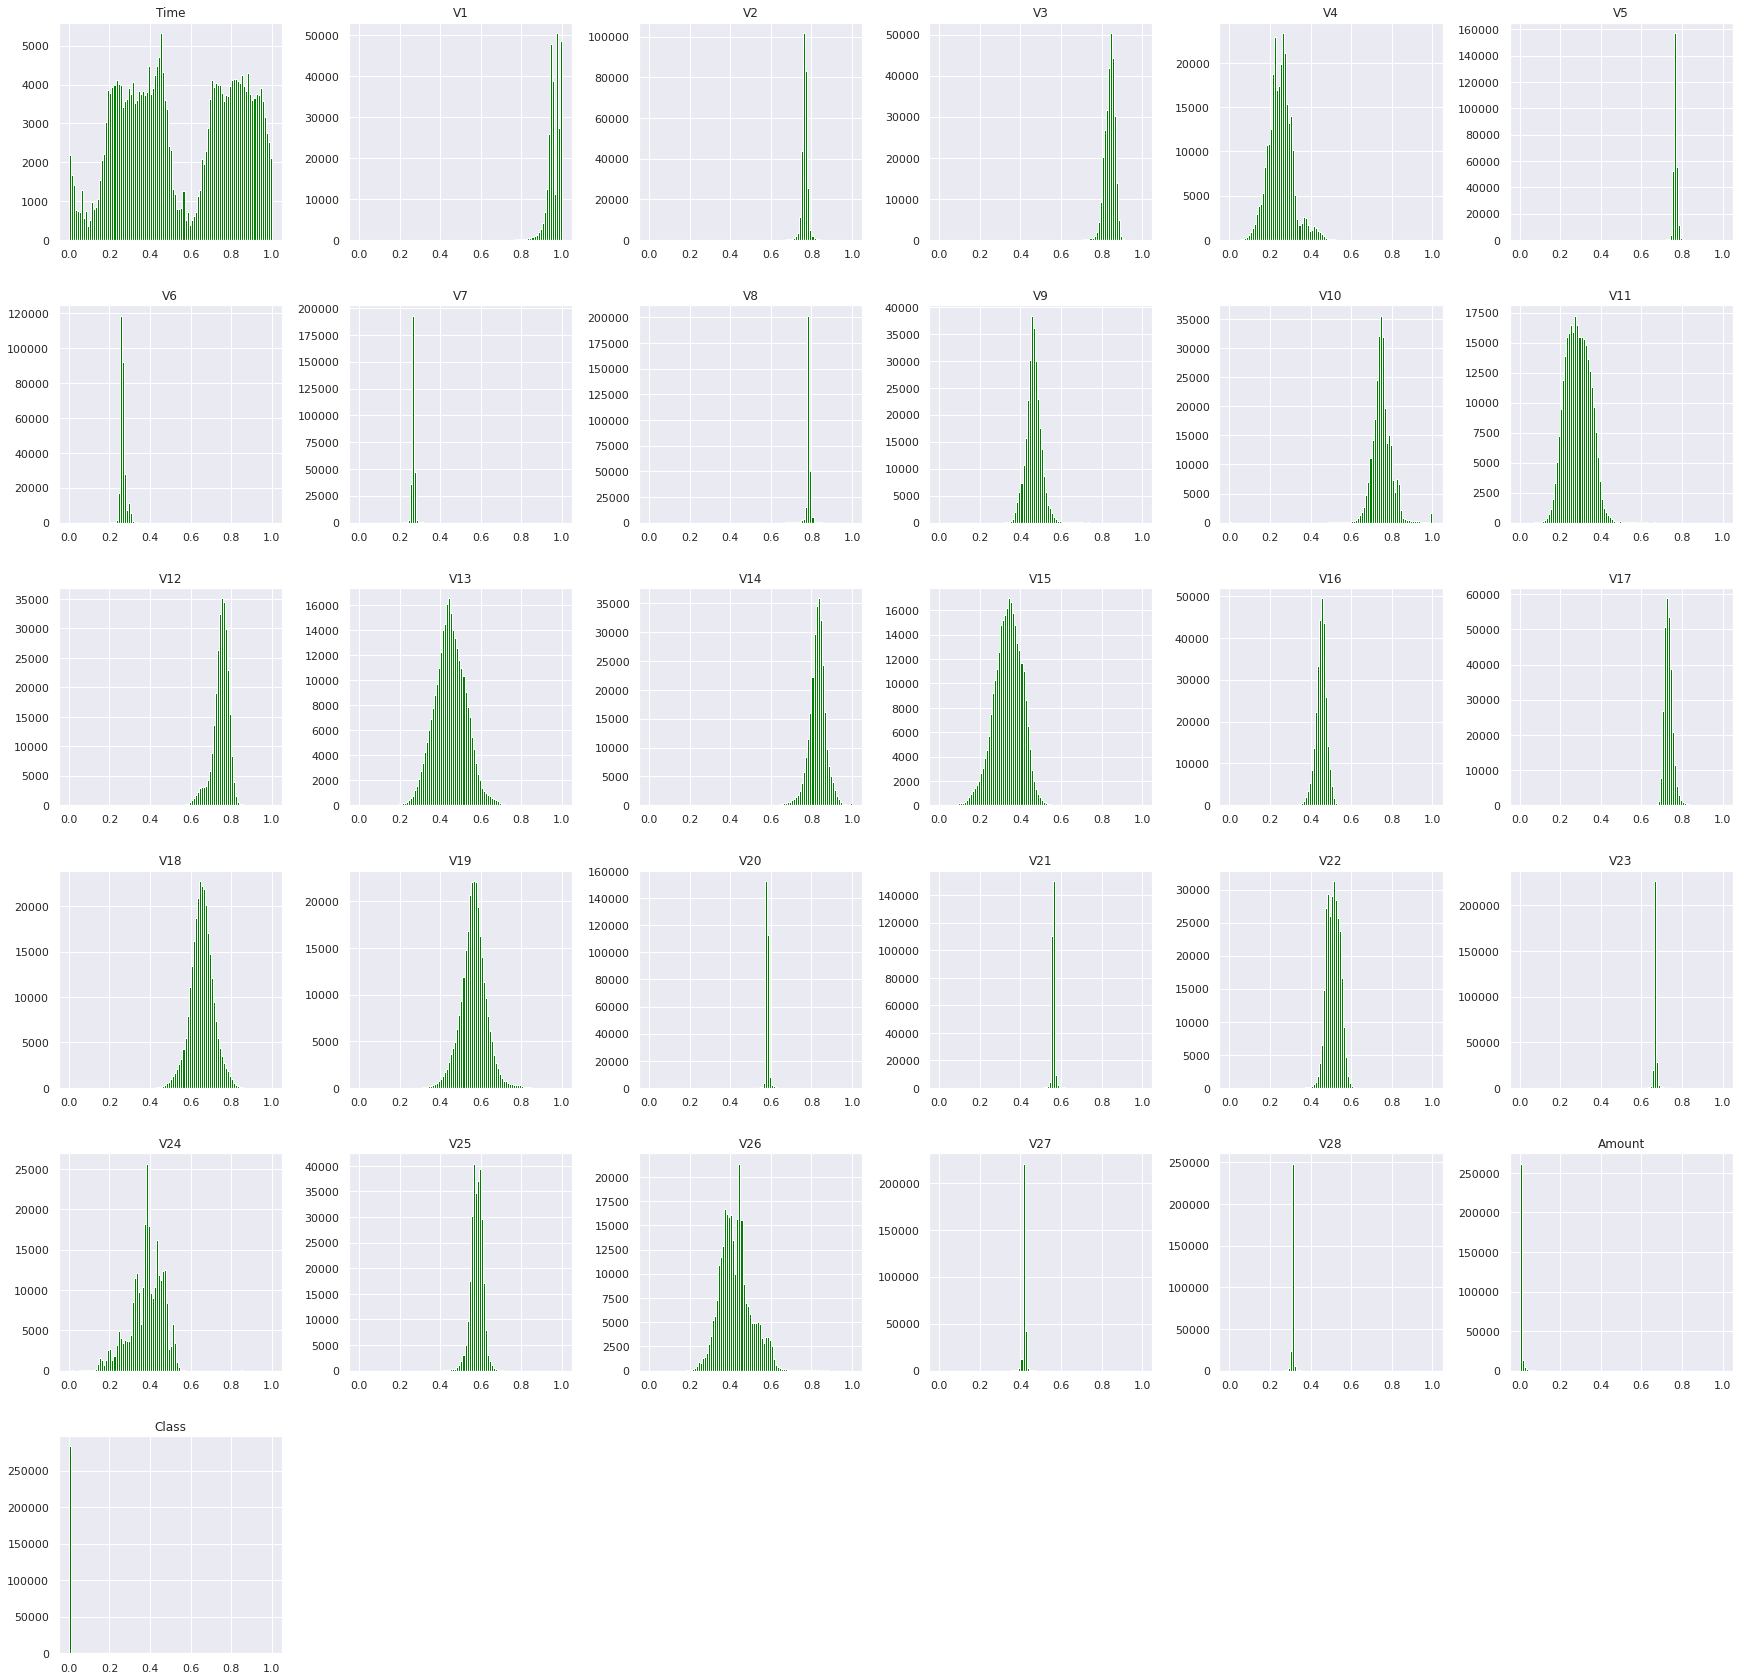

In [ ]:
%matplotlib inline  
sns.set()
df.hist(bins=100, figsize=(30, 30), color='green')
plt.show()

We observe that the total  number of transactions and the values of the generated transactions correspond with what we expect from the GAN oversampling.

Indeed, here we can see how the distribution of classes correspond to 50%. Later we will change this value to understand how this will impact our model performance

## 5.2.3 Classifiers with GAN without Cross Validation

We first start with a default Logistic regression to understand whether everything seems to work properly

In [ ]:
def performance_assessment(predictions,original_ytest, fraud_proportion, oversampling,rounded =True):
    
    AUC_ROC = metrics.roc_auc_score(original_ytest, predictions)
    precision = metrics.precision_score(original_ytest, predictions)
    recall = metrics.recall_score(original_ytest, predictions)
    f1_score = metrics.f1_score(original_ytest, predictions)
    
    performances = pd.DataFrame([[AUC_ROC, precision, recall,f1_score]], 
                           columns=['AUC ROC',' Precision',' Recall', 'f1_score'])
    
    if rounded:
        performances = performances.round(3)
    performances.index=[ fraud_proportion + oversampling]
    return performances
def performance_assessment_model_collection_gan(fitted_models_and_predictions_dictionary, 
                                            test, 
                                            type_set='test'):

    performances=pd.DataFrame() 
    
    for classifier_name, model_and_predictions in fitted_models_and_predictions_dictionary.items():
    
        predictions=model_and_predictions['predictions_'+type_set]
        
        performances_model=performance_assessment(predictions, original_ytest)
        performances_model.index=[classifier_name + '_gan']
        
        performances=performances.append(performances_model)
        
    return performances



In [ ]:
from xgboost import XGBClassifier
#from XGBoost import XGBClassifier
performance_gan = pd.DataFrame()
for alpha in proportion:
    dataset_name =  'new_balanced_dataset_gan' + str(alpha)
    X_train_gan = np.array(balanced_datasets_gan[dataset_name].drop('Class', axis = 1))
    y_train_gan = np.array(balanced_datasets_gan[dataset_name]['Class'])  
    xgb_clf= XGBClassifier(eta = 0.3,max_depth = 4 )
    xgb_clf.fit(X_train_gan, y_train_gan)
    predictions_test = xgb_clf.predict(original_Xtest)
    performance_gan = performance_gan.append(performance_assessment(predictions_test,original_ytest, str(alpha), '_gan'))
    print('here')
performance_gan

here
here
here
here
here
here
here


,AUC ROC,Precision,Recall,f1_score
0.02_gan,0.826,0.954,0.653,0.775
0.05_gan,0.832,0.955,0.663,0.783
0.1_gan,0.837,0.955,0.674,0.790
0.2_gan,0.853,0.918,0.705,0.798
0.3_gan,0.847,0.943,0.695,0.800
0.4_gan,0.837,0.889,0.674,0.766
0.5_gan,0.831,0.875,0.663,0.754


In [ ]:
from imblearn.over_sampling import SMOTE
performance_smote = pd.DataFrame()
# SMOTE Technique (OverSampling) After splitting and Cross Validating
for alpha in proportion:
    sm = SMOTE(ratio=alpha/(1-alpha), random_state=42)
    Xsm_train, ysm_train = sm.fit_sample(original_Xtrain, original_ytrain)
    xgb_clf= XGBClassifier(eta = 0.3,max_depth = 4 )
    xgb_clf.fit(Xsm_train, ysm_train)
    predictions_test = xgb_clf.predict(original_Xtest)
    performance_smote = performance_smote.append(performance_assessment(predictions_test,original_ytest, str(alpha), '_smote'))
    print('here')
performance_smote

here
here
here
here
here
here
here


,AUC ROC,Precision,Recall,f1_score
0.02_smote,0.853,0.957,0.705,0.812
0.05_smote,0.858,0.932,0.716,0.810
0.1_smote,0.863,0.885,0.726,0.798
0.2_smote,0.868,0.833,0.737,0.782
0.3_smote,0.874,0.807,0.747,0.776
0.4_smote,0.879,0.837,0.758,0.796
0.5_smote,0.884,0.768,0.768,0.768


In [ ]:
performance_total = performance_gan.append(performance_smote)
performance_total

,AUC ROC,Precision,Recall,f1_score
0.02_gan,0.826,0.954,0.653,0.775
0.05_gan,0.832,0.955,0.663,0.783
0.1_gan,0.837,0.955,0.674,0.790
0.2_gan,0.853,0.918,0.705,0.798
0.3_gan,0.847,0.943,0.695,0.800
0.4_gan,0.837,0.889,0.674,0.766
0.5_gan,0.831,0.875,0.663,0.754
0.02_smote,0.853,0.957,0.705,0.812
0.05_smote,0.858,0.932,0.716,0.810
0.1_smote,0.863,0.885,0.726,0.798


In [ ]:
xgb_clf= XGBClassifier(eta = 0.3,max_depth = 4 )
xgb_clf.fit(original_Xtrain, original_ytrain)
predictions_test_nosampling = xgb_clf.predict(original_Xtest)
performance_nosampling = performance_assessment(predictions_test_nosampling,original_ytest, 'original', 'none')

In [ ]:
performance_smote_nosampling = performance_smote.append(performance_nosampling)

In [ ]:
performance_smote_nosampling = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tesi/Versione agosto/CHAPTER 6: APPLICATION ON A REAL DATASET/table performance/qualcosa',index_col = 'Unnamed: 0')

In [ ]:
performance_smote_nosampling.to_csv('/content/drive/MyDrive/Colab Notebooks/tesi/Versione agosto/CHAPTER 6: APPLICATION ON A REAL DATASET/table performance/smote_nosampling.csv')

In [ ]:
performance_total = performance_total.append(performance_nosampling)
performance_total

,AUC ROC,Precision,Recall,f1_score
0.02_gan,0.826,0.954,0.653,0.775
0.05_gan,0.832,0.955,0.663,0.783
0.1_gan,0.837,0.955,0.674,0.790
0.2_gan,0.853,0.918,0.705,0.798
0.3_gan,0.847,0.943,0.695,0.800
0.4_gan,0.837,0.889,0.674,0.766
0.5_gan,0.831,0.875,0.663,0.754
0.02_smote,0.853,0.957,0.705,0.812
0.05_smote,0.858,0.932,0.716,0.810
0.1_smote,0.863,0.885,0.726,0.798


In [ ]:
performance_total.to_csv('/content/drive/MyDrive/Colab Notebooks/tesi/Versione agosto/CHAPTER 6: APPLICATION ON A REAL DATASET/table performance/performance_total_pulito.csv')

In [ ]:
for alpha in proportion:
    dataset_name =  'new_balanced_dataset_gan' + str(alpha) 
    path = '/content/drive/MyDrive/Colab Notebooks/tesi/Versione agosto/CHAPTER 6: APPLICATION ON A REAL DATASET/gan datset/gan dataset pulito/' + dataset_name + '.csv'
    balanced_datasets_gan[dataset_name].to_csv(path)

In [ ]:
#Gradient Boosting
from sklearn.model_selection import GridSearchCV
xgboost_params = {'max_depth': [4,6,8,10],'eta': [0.1,0.2,0.3]}
X_train_gan = np.array(balanced_datasets_gan['new_balanced_dataset_gan0.2'].drop('Class', axis = 1))
y_train_gan = np.array(balanced_datasets_gan['new_balanced_dataset_gan0.2']['Class'])
grid_xgboost = GridSearchCV(XGBClassifier(), xgboost_params,cv = 3,  scoring = ['f1','recall','roc_auc','precision'], refit = 'roc_auc' )
grid_xgboost.fit(X_train_gan, y_train_gan)


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'eta': [0.1, 0.2, 0.3], 'max_depth': [4, 6, 8, 10]},
             pre_dispatch='2*n_jobs', refit='roc_auc', return_train_score=False,
             scori

In [ ]:
grid_xgboost_df = pd.DataFrame(grid_xgboost.cv_results_)
grid_xgboost_df.to_csv('/content/drive/MyDrive/Colab Notebooks/tesi/Versione agosto/CHAPTER 5: APPLICATION ON A SIMULATED DATASET/gan datasets/with sigmoid/grid classifier/grid_xgboost.csv')

In [ ]:
from xgboost import XGBClassifier
X_train_gan = np.array(balanced_datasets_gan['new_balanced_dataset_gan0.2'].drop('Class', axis = 1))
y_train_gan = np.array(balanced_datasets_gan['new_balanced_dataset_gan0.2']['Class'])  
xgb_clf= XGBClassifier(eta = 0.2,max_depth = 4 )
xgb_clf.fit(X_train_gan, y_train_gan)
predictions_test_gan = xgb_clf.predict(original_Xtest)
performance_gan_final = performance_assessment(predictions_test_gan,original_ytest, str(0.2), '_gan')
performance_gan_final

,AUC ROC,Precision,Recall,f1_score
0.2_gan,0.853,0.918,0.705,0.798


In [ ]:
# SMOTE Technique (OverSampling) After splitting and Cross Validating
sm = SMOTE(ratio=0.2/(1-0.2), random_state=42)
Xsm_train, ysm_train = sm.fit_sample(original_Xtrain, original_ytrain)
xgb_clf= XGBClassifier(eta = 0.2,max_depth = 4 )
xgb_clf.fit(Xsm_train, ysm_train)
predictions_test_smote = xgb_clf.predict(original_Xtest)
performance_smote_final = performance_assessment(predictions_test_smote,original_ytest, str(0.2), '_smote')
performance_smote_final

,AUC ROC,Precision,Recall,f1_score
0.2_smote,0.868,0.833,0.737,0.782


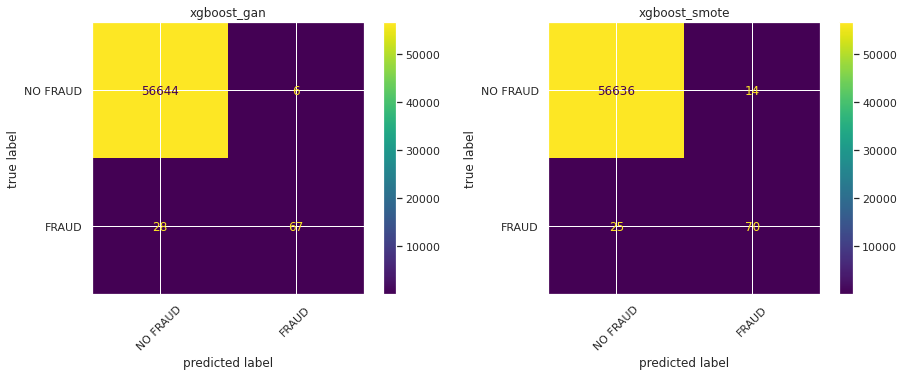

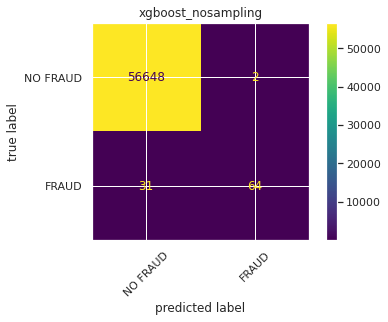

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
labels = ['NO FRAUD', 'FRAUD']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

cf_matrix = confusion_matrix(original_ytest, predictions_test_gan)
disp = ConfusionMatrixDisplay(cf_matrix,display_labels=labels)
disp.plot(xticks_rotation=45, ax=axes[0], values_format = 'g' )
disp.ax_.set_title('xgboost' + '_gan')
disp.ax_.set_xlabel('predicted label')
disp.ax_.set_ylabel('true label')


cf_matrix = confusion_matrix(original_ytest, predictions_test_smote)
disp = ConfusionMatrixDisplay(cf_matrix,display_labels=labels)
disp.plot(xticks_rotation=45, ax=axes[1], values_format = 'g' )
disp.ax_.set_title('xgboost' + '_smote')
disp.ax_.set_xlabel('predicted label')
disp.ax_.set_ylabel('true label')
plt.show()

cf_matrix = confusion_matrix(original_ytest, predictions_test_nosampling)
disp = ConfusionMatrixDisplay(cf_matrix,display_labels=labels)
disp.plot(xticks_rotation=45, values_format = 'g' )
disp.ax_.set_title('xgboost' + '_nosampling')
disp.ax_.set_xlabel('predicted label')
disp.ax_.set_ylabel('true label')
plt.show()